<a href="https://colab.research.google.com/github/artsasse/pergola-grape-count/blob/main/grape_cluster_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Feb 15 23:28:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [ ]:
!pip install ultralytics==8.3.19

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.19 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.4/112.6 GB disk)


## Install Roboflow Supervision

In [ ]:
!pip install supervision[assets]==0.24.0

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.24.0


## Load annotated dataset

In this case we are importing the dataset from Roboflow. You need to fill the `api_key`, `workspace`, `project`, `version` and `download` parameters to download your own dataset.



In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("").project("")
version = project.version()
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


## Train YOLOv8 on custom dataset (skip)

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=200 imgsz=640 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 126MB/s]
New https://pypi.org/project/ultralytics/8.3.72 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.19 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/cacho-roxo-2/data.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, re

## Export model to zip file (skip)

In [ ]:
# !zip -r weights.zip runs/detect/train/weights

  adding: runs/detect/train/weights/ (stored 0%)
  adding: runs/detect/train/weights/best.pt (deflated 8%)
  adding: runs/detect/train/weights/last.pt (deflated 8%)


## Import model from zip file

In [ ]:
!unzip weights.zip

Archive:  weights.zip
   creating: runs/detect/train/weights/
  inflating: runs/detect/train/weights/best.pt  
  inflating: runs/detect/train/weights/last.pt  


## Load Pre-Trained YOLOv8

In [ ]:
from ultralytics import YOLO

MODEL = 'best.pt'
model = YOLO(MODEL)
model.fuse()

Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


## Predict and annotate single frame

In [ ]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

SELECTED_CLASS_IDS = [0]

In [ ]:
import supervision as sv
import numpy as np

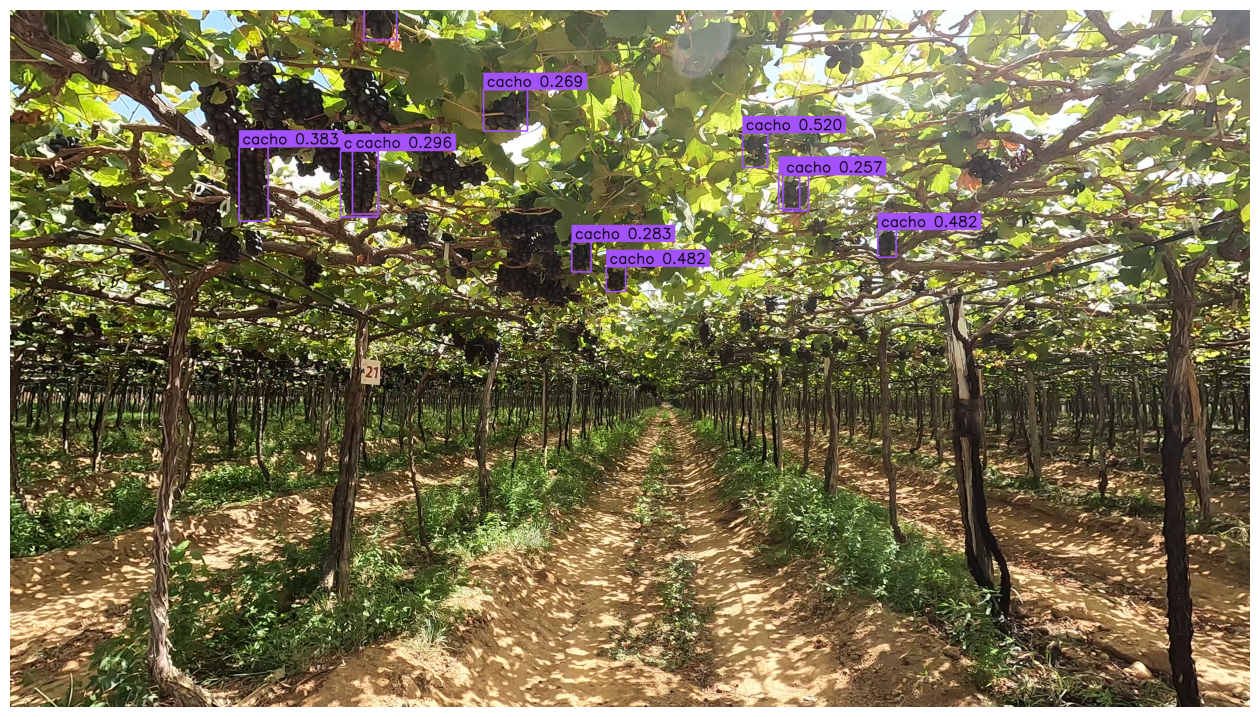

In [ ]:
SOURCE_VIDEO_PATH = "original-4k-3a13(96).mp4"
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LabelAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.3f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Predict and annotate whole video

In [ ]:
# settings
LINE_START = sv.Point(0 + 50, 500)
LINE_END = sv.Point(3840 - 50, 500)

TARGET_VIDEO_PATH = f"{HOME}/result.mp4"

In [ ]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=29, total_frames=300)

In [ ]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3)

byte_tracker.reset()

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator, LabelAnnotator, and TraceAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)